In [6]:
!pip install numpy pandas statsmodels matplotlib seaborn prophet sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.theta import ThetaModel
from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from prophet import Prophet

try:
  from google.colab import files
  uploaded = files.upload()
  IN_COLAB = True
except:
  IN_COLAB = False

import warnings
warnings.filterwarnings('once')

Saving ConsumptionIndustry.csv to ConsumptionIndustry (1).csv
Saving ELSpotPrices.csv to ELSpotPrices.csv


Functions

In [8]:
def sample_data(df, start_date):
  start_date = datetime.strptime(start_date, '%Y-%m-%d')
  end_date = df.index[-1]
  return df[(df.index >= start_date) & (df.index <= end_date)]

def sample_data_with_train_window(df, start_date, train_window_size):
  start_date = datetime.strptime(start_date, '%Y-%m-%d') - timedelta(hours=train_window_size)
  end_date = df.index[-1]
  return df[(df.index >= start_date) & (df.index <= end_date)]

def get_next_window(data, train_window_size, forecast_horizon):
  return data[:train_window_size], data[train_window_size:train_window_size + forecast_horizon]

def forecast_whitebox_model(model, forecast_horizon, model_name, exog_data_test=None):
  model_res = model.fit()

  if "SARIMA" in model_name and "STL" not in model_name:
    return model_res.get_forecast(steps=forecast_horizon, exog=exog_data_test).predicted_mean
  else:
    return model_res.forecast(steps=forecast_horizon)

def plot_data(df):
  plt.plot(df)
  plt.title('Consumption in dk private households')
  plt.xlabel('Measurements')
  plt.ylabel('Power (kW / charger)')
  plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Initializing time series

In [9]:
# Consumption data
df = pd.read_csv('../Dataset/ConsumptionIndustry.csv' if not IN_COLAB else 'ConsumptionIndustry.csv', sep=';')
df['HourDK'] = pd.to_datetime(df['HourDK'])
df['ConsumptionkWh'] = df['ConsumptionkWh'].str.replace(",", ".").astype(float)
df.index = df['HourDK']

# format data here
df.drop(columns=['HourUTC', 'HourDK', 'MunicipalityNo', 'Branche'], inplace=True)

In [10]:
# El-spot prices
df2 = pd.read_csv('../Dataset/ELSpotPrices.csv' if not IN_COLAB else 'ELSpotPrices.csv', sep=';')
df2['HourDK'] = pd.to_datetime(df2['HourDK'])
df2['SpotPriceDKK'] = df2['SpotPriceDKK'].str.replace(",", ".").astype(float)
df2.index = df2['HourDK']
df2 = df2.iloc[1:] # remove first row, since the measurement at that time is not present in other dataset
df2.drop(columns=['HourUTC', 'HourDK', 'PriceArea', 'SpotPriceEUR'], inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Runs a model in Sliding Window forecasting style

In [18]:
model_name = 'ThetaModel'
date_start = '2023-11-01'
window_train_size = 24*7*2 #hours
forecast_horizon = 24 #hours

data = sample_data_with_train_window(df, date_start, window_train_size) # start: date_start - window_train_size, end: last date in df
# exog_data = sample_data_with_train_window(df2, date_start, window_train_size)
# plot_data(data)
results = np.array([])
iterations = 0

warnings.filterwarnings("ignore")

while len(data) > window_train_size + forecast_horizon:
  data_train, data_test = get_next_window(data, window_train_size, forecast_horizon)
  # exog_data_train, exog_data_test = get_next_window(exog_data, window_train_size, forecast_horizon)
  model = ThetaModel(data_train, period=24, deseasonalize=True, use_test=True, method='additive', difference=True)
  predictions = forecast_whitebox_model(model, forecast_horizon, model_name)

  results = np.append(results, predictions.values)
  iterations += 1
  data = data.iloc[forecast_horizon:] # move window by forecast_horizon
  # exog_data = exog_data.iloc[forecast_horizon:]

warnings.filterwarnings("default")

result_table = pd.DataFrame(results)
result_table.index = pd.date_range(start=date_start, periods=forecast_horizon*iterations, freq='h')

if IN_COLAB:
  result_table.to_csv(f'{window_train_size}_{forecast_horizon}_{model_name}.csv')
else:
  result_table.to_csv(f'../Results/Whitebox/Forecasting/{window_train_size}_{forecast_horizon}_{model_name}.csv', header=False)

                                0
2023-11-01 00:00:00  32322.237730
2023-11-01 01:00:00  30654.533350
2023-11-01 02:00:00  29289.038986
2023-11-01 03:00:00  27695.917988
2023-11-01 04:00:00  25801.326129
...                           ...
2024-11-10 19:00:00  54545.169455
2024-11-10 20:00:00  46866.732722
2024-11-10 21:00:00  41477.676269
2024-11-10 22:00:00  41054.792036
2024-11-10 23:00:00  35867.308025

[9024 rows x 1 columns]


Models

In [ ]:
  # model = SARIMAX(endog = data_train, order = (1, 1, 4), seasonal_order = (1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
  # model = STLForecast(data_train, SARIMAX, model_kwargs=dict(order=(1, 1, 1), seasonal_order = (1, 1, 1, 12)), period=24)
  # model = ThetaModel(data_train, period=24, method="additive")
  # model = ThetaModel(data_train, period=24, method="multiplicative")
  # model = DynamicFactorMQ(endog=data_train)

Plot of forecasts

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


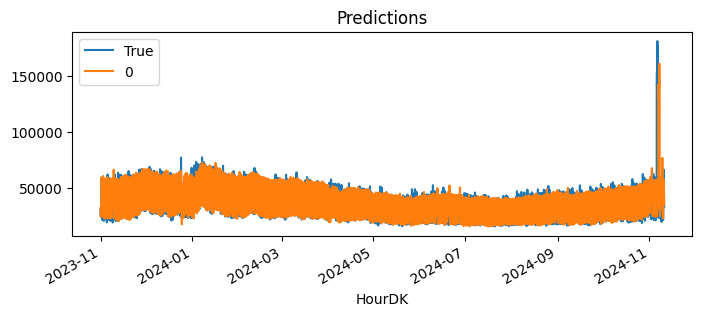

In [16]:
# prediction_Theta_additive = pd.read_csv('../Results/Whitebox/Forecasting/336_24_ThetaModel_additive.csv', header=None, index_col=0, names=['Prediction'])
# prediction_Theta_additive.index = pd.to_datetime(prediction_Theta_additive.index)
# prediction_Theta_multiplicative = pd.read_csv('../Results/Whitebox/Forecasting/336_24_ThetaModel_multiplicative.csv', header=None, index_col=0, names=['Prediction'])
# prediction_Theta_multiplicative.index = pd.to_datetime(prediction_Theta_multiplicative.index)
# prediction_DynamicFactorMQ = pd.read_csv('../Results/Whitebox/Forecasting/336_24_DynamicFactorMQ.csv', header=None, index_col=0, names=['Prediction'])
# prediction_DynamicFactorMQ.index = pd.to_datetime(prediction_DynamicFactorMQ.index)
# predictions = pd.read_csv('../Results/Whitebox/Forecasting/336_24_SARIMAX.csv', header=None, index_col=0, names=['Prediction'])
# predictions.index = pd.to_datetime(predictions.index)

fig, ax = plt.subplots(figsize=(8, 3))
data['ConsumptionkWh'].plot(ax=ax, label='True')
result_table.plot(ax=ax, label='Predictions')
# predictions['Prediction'].plot(ax=ax, label='SARIMAX')
# prediction_Theta_additive['Prediction'].plot(ax=ax, label='Theta_additive')
# prediction_Theta_multiplicative['Prediction'].plot(ax=ax, label='Theta_multiplicative')
# prediction_DynamicFactorMQ['Prediction'].plot(ax=ax, label='DynamicFactorMQ')
ax.set_title('Predictions')
ax.legend()

Evaluate algorithm performance

In [ ]:
# def evaluate(prediction, name):
#     print(f"-- {name} --")
#     print(f"mse: {mean_squared_error(data, prediction)}") #penalizes larger errors more
#     print(f"rmse: {root_mean_squared_error(data, prediction)}")

# data = sample_data(df, date_start)

# evaluate(prediction_Theta_additive['Prediction'], 'Theta_additive')
# evaluate(prediction_Theta_multiplicative['Prediction'], 'Theta_multiplicative')
# evaluate(prediction_DynamicFactorMQ['Prediction'], 'DynamicFactorMQ')
